In [ ]:
pip install tensorflow==2.15.0

In [ ]:
pip install --upgrade tensorflow-addons

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow Version:", tf.__version__)

2024-11-25 17:44:13.032365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 17:44:13.032432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 17:44:13.034140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.15.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = r"/kaggle/input/hsv-dataset/Alzheimer_HSV/Train"
test_dir = r"/kaggle/input/hsv-dataset/Alzheimer_HSV/Test"

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15,rotation_range=20,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,target_size = (128,128),seed=1,
                                                   class_mode = 'categorical',subset = 'training',batch_size = 32)

valid_dataset = train_datagen.flow_from_directory(directory = train_dir,target_size = (128,128),seed=1,
                                                   class_mode = 'categorical',subset = 'validation',batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,target_size = (128,128),seed=1,
                                                class_mode = 'categorical',batch_size = 16)

Found 4355 images belonging to 4 classes.
Found 766 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
import os

base_dir = "/kaggle/input/hsv-dataset/Alzheimer_HSV"
print("Contents of Base Directory:", os.listdir(base_dir))


Contents of Base Directory: ['Test', 'Train']


In [5]:
import os
from distutils.dir_util import copy_tree, remove_tree

base_dir = r"/kaggle/input/hsv-dataset/Alzheimer_HSV"
root_dir = "./"
train_dir = os.path.join(base_dir, "/kaggle/input/hsv-dataset/Alzheimer_HSV/Train")  # Corrected: train now points to train directory
test_dir = os.path.join(base_dir, "/kaggle/input/hsv-dataset/Alzheimer_HSV/Test")    # Corrected: test now points to test directory
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
# Define augmentation parameters
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR = './dataset/'
DIM = (176, 176)

# Create ImageDataGenerator
work_dr = ImageDataGenerator(
    rescale = 1./255, 
    brightness_range=BRIGHT_RANGE, 
    zoom_range=ZOOM, 
    data_format=DATA_FORMAT, 
    fill_mode=FILL_MODE, 
    horizontal_flip=HORZ_FLIP
)

# Generate augmented data
train_data_gen = work_dr.flow_from_directory(
    directory=WORK_DIR, 
    target_size=DIM, 
    batch_size=6500, 
    shuffle=False
)

Found 6400 images belonging to 4 classes.


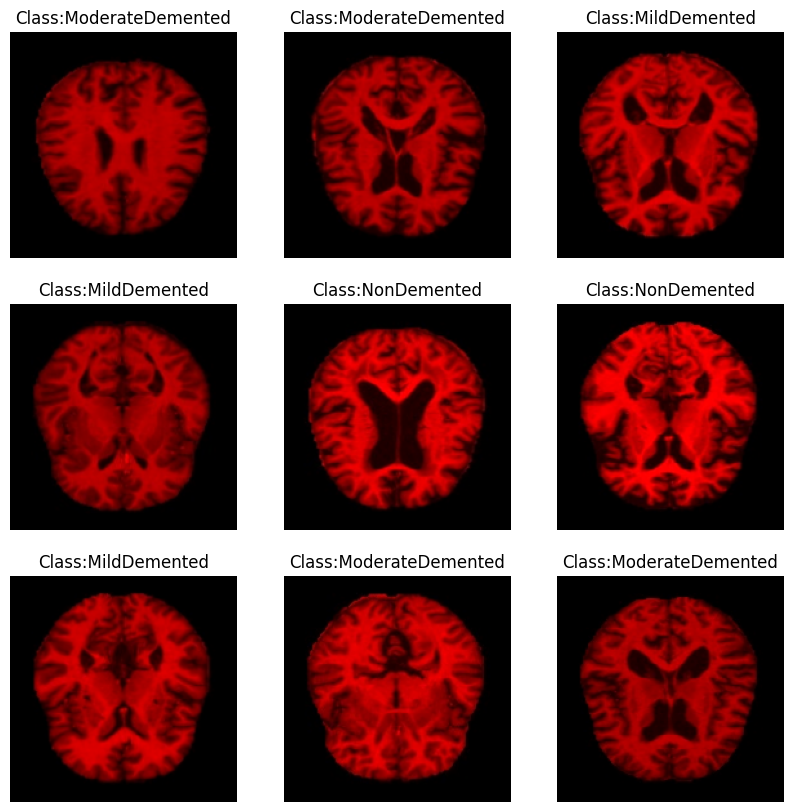

In [10]:
def show_images(generator,y_pred=None):

    labels =dict(zip([0,1,2,3], CLASSES))

    x,y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
show_images(train_data_gen)

In [11]:
train_data, train_labels = train_data_gen.next()

In [12]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [13]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [14]:

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [15]:
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121

densenet_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [16]:
# Freeze layers in the base model
for layer in densenet_model.layers:
    layer.trainable = False

In [17]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
custom_densenet_model = Sequential([
    densenet_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')        
], name="densenet_cnn_model")


In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

custom_densenet_model.compile(optimizer='rmsprop',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)

custom_densenet_model.summary()

Model: "densenet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 5, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)        

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
CALLBACKS = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

EPOCHS = 100
history = custom_densenet_model.fit(
    train_data, 
    train_labels,
    validation_data=(val_data, val_labels),
    callbacks=CALLBACKS,
    epochs=EPOCHS
)

Epoch 1/100


2024-11-25 17:50:56.643415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1732557060.067827    1498 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 [==============================] - 30s 76ms/step - loss: 1.4003 - acc: 0.4054 - auc: 0.6723 - f1_score: 0.4012 - val_loss: 0.7967 - val_acc: 0.6328 - val_auc: 0.8880 - val_f1_score: 0.5765 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 13s 51ms/step - loss: 0.9273 - acc: 0.5828 - auc: 0.8446 - f1_score: 0.5722 - val_loss: 0.6549 - val_acc: 0.6753 - val_auc: 0.9188 - val_f1_score: 0.6378 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 13s 51ms/step - loss: 0.7909 - acc: 0.6425 - auc: 0.8859 - f1_score: 0.6364 - val_loss: 0.5822 - val_acc: 0.7300 - val_auc: 0.9376 - val_f1_score: 0.7234 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 13s 51ms/step - loss: 0.7314 - acc: 0.6704 - auc: 0.9024 - f1_score: 0.6680 - val_loss: 0.5651 - val_acc: 0.7534 - val_auc: 0.9419 - val_f1_score: 0.7473 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 13s 51ms/step - loss: 0.7028 - acc: 0.6898 - auc: 0.9107 - f1_score: 

64/64 [==============================] - 4s 36ms/step


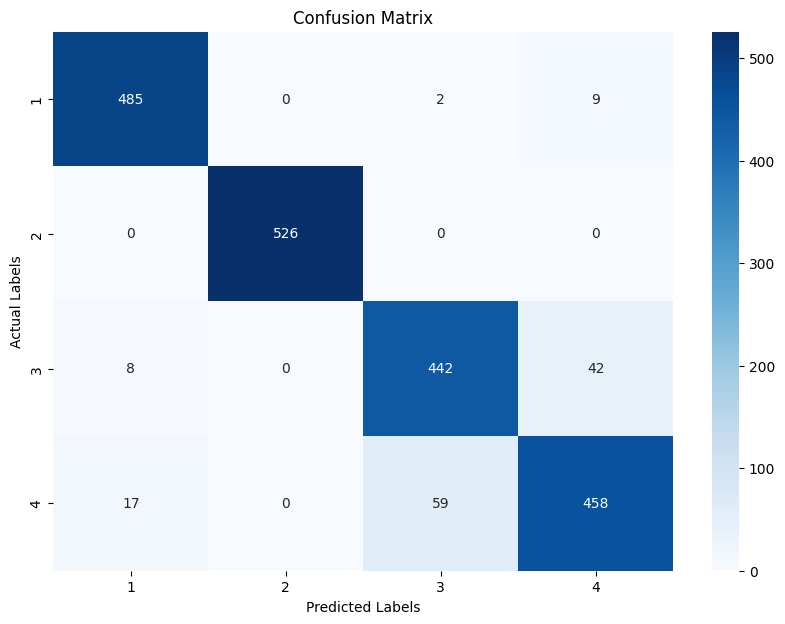

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Assuming val_data and val_labels are your validation datasets
predictions = custom_densenet_model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

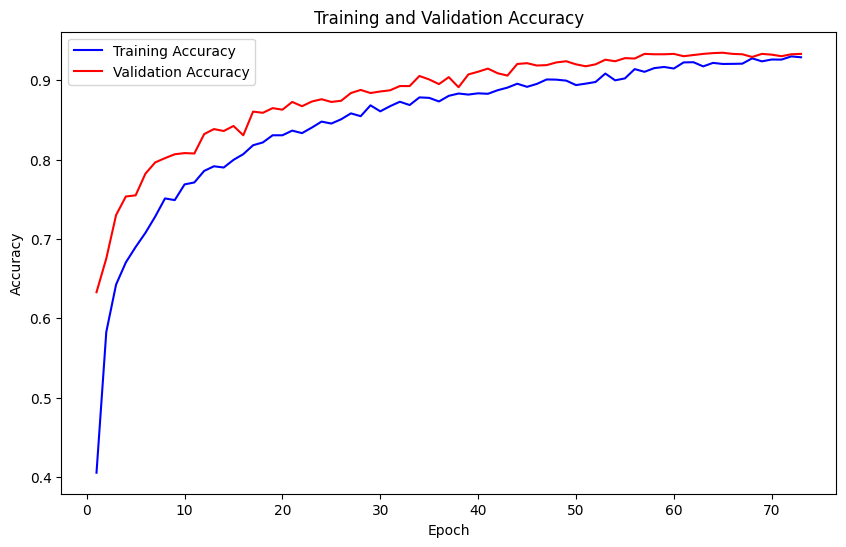

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
custom_densenet_model.save('densenet_model.h5', save_format='h5')  

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Use the model you trained earlier
predictions = custom_densenet_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print(report)

80/80 [==============================] - 3s 36ms/step
                  precision    recall  f1-score   support

     NonDemented       0.96      0.97      0.96       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.90      0.87      0.88       662
ModerateDemented       0.85      0.87      0.86       624

        accuracy                           0.93      2560
       macro avg       0.93      0.93      0.93      2560
    weighted avg       0.93      0.93      0.93      2560



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


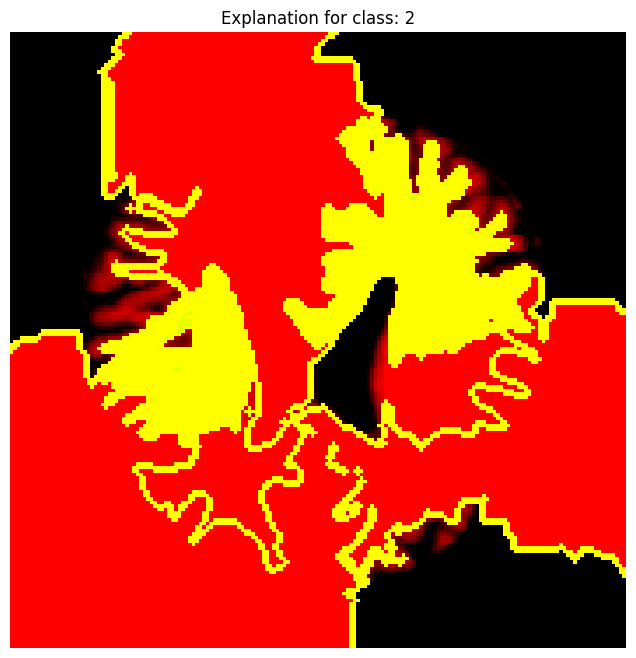

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


def preprocess_image(img_path, target_size=(176, 176)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

image_path =r"/kaggle/input/hsv-dataset/Alzheimer_HSV/Test/VeryMildDemented/hsv_27 (11).jpg"
preprocessed_img = preprocess_image(image_path)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img[0].astype('double'), 
                                         custom_densenet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Explanation for class: {explanation.top_labels[0]}')
plt.axis('off') 
plt.show()
